In [37]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from transformers import get_scheduler
from tqdm import tqdm

In [38]:
data_path = "labeled_recipes.csv"
recipes_df = pd.read_csv(data_path)

In [39]:
def extract_quantity(ingredient):
    quantities = re.findall(r'\d+\/\d+|\d+\.\d+|\d+', ingredient)
    return sum([eval(q) for q in quantities]) if quantities else 0

recipes_df['ingredient_quantity'] = recipes_df['ingredients'].apply(lambda x: sum(extract_quantity(ing) for ing in x.split('\n')))


def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text


recipes_df['ingredients'] = recipes_df['ingredients'].apply(clean_text)
recipes_df['instructions'] = recipes_df['instructions'].apply(clean_text)
recipes_df['ingredient_quantity'] = recipes_df['ingredient_quantity'].astype(str)

In [40]:
recipes_df.head()

,title,ingredients,instructions,label,ingredient_quantity
0,Best Meatloaf,2 pounds ground beef ¼ cup bread crumbs 1 slic...,preheat oven to 375f 175c combine ketchup brow...,regular,11.0
1,Chicken Lo Mein,1 pound chicken breasts 8 ounces dry lo mein n...,in a small bowl whisk together sauce ingredien...,regular,39.0
2,Easy Homemade Mac and Cheese,8 ounces elbow macaroni uncooked cheese sauce ...,cook elbow macaroni according to package instr...,regular,23.0
3,Chocolate Cake,1 ¼ cups allpurpose flour 1 ¼ cups granulated ...,preheat oven to 350 degrees f line two 6 round...,regular,5.0
4,Crock Pot Teriyaki Chicken,2 pounds chicken breasts ½ cup honey ¾ cup soy...,grease the container of a large slow cooker ad...,regular,7.0


In [41]:
recipes_df["text"] = recipes_df["ingredients"] + " " + recipes_df["instructions"] + " " + recipes_df["ingredient_quantity"]
recipes_df["label_encoded"] = recipes_df["label"].map({"regular": 0, "fitness": 1})

In [42]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    recipes_df["text"], recipes_df["label_encoded"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [43]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

In [44]:
class RecipeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = RecipeDataset(train_encodings, list(train_labels))
val_dataset = RecipeDataset(val_encodings, list(val_labels))
test_dataset = RecipeDataset(test_encodings, list(test_labels))

In [45]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [46]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [47]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
epochs = 3
progress_bar = tqdm(range(num_training_steps))
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    train_loss = 0
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            val_loss += outputs.loss.item()
            preds = torch.argmax(logits, axis=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += len(batch["labels"])
    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_loader)) 
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.3f}, Val Loss = {val_losses[-1]:.3f}, Val Accuracy = {val_accuracies[-1]:.3f}")


  0%|          | 0/15 [22:17:42<?, ?it/s]


Epoch 1: Train Loss = 0.692, Val Loss = 0.773, Val Accuracy = 0.273
Epoch 2: Train Loss = 0.613, Val Loss = 0.585, Val Accuracy = 0.727
Epoch 3: Train Loss = 0.576, Val Loss = 0.633, Val Accuracy = 0.545


In [49]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=-1).cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

print("\nClassification Report on Test Set:")
print(classification_report(true_labels, predictions, target_names=["regular", "fitness"]))


Classification Report on Test Set:
              precision    recall  f1-score   support

     regular       0.75      0.43      0.55         7
     fitness       0.50      0.80      0.62         5

    accuracy                           0.58        12
   macro avg       0.62      0.61      0.58        12
weighted avg       0.65      0.58      0.57        12



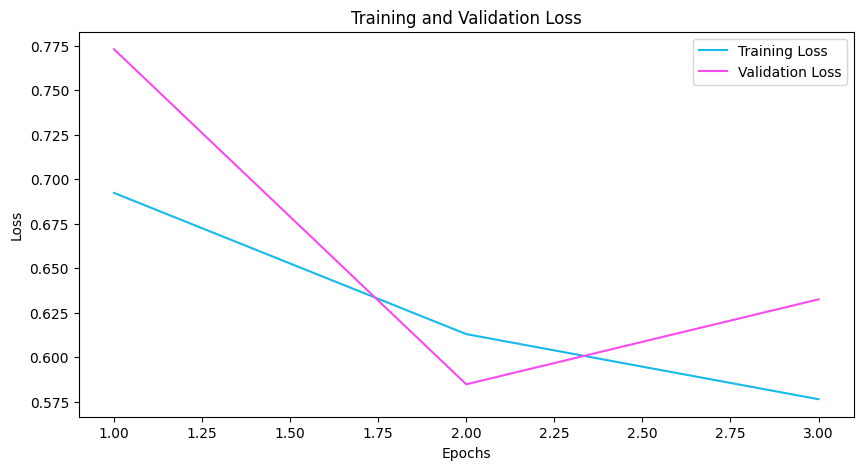

In [50]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label="Training Loss", color="#14baea")
plt.plot(epochs_range, val_losses, label="Validation Loss", color="#f84af0")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


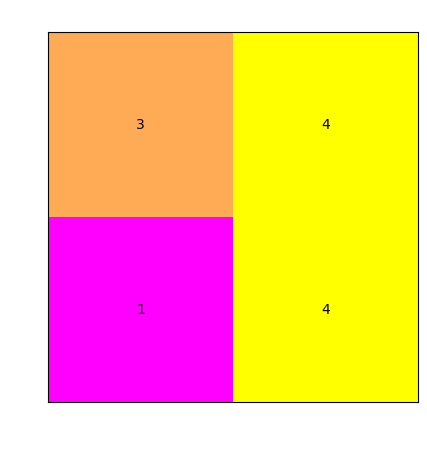

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='spring', ax=ax, colorbar=False)

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

for text in ax.texts:
    text.set_color("black")

plt.title('Confusion Matrix', color='white')

ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.tick_params(colors="white")
labels = ["regular", "fitness"]


plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
plt.show()